In [1]:
#import libraries
import pandas as pd
import numpy as np
import json
import requests
import networkx
import scipy

In [3]:
#create empty dataframe, enter api key and show name as variables
#enter show search url as variable
#search for show id 
df_master = pd.DataFrame()
api_key = "k_793904nk/" 
show = "Wynonna Earp" 
show_search_url = "https://imdb-api.com/en/API/SearchTitle/" + api_key + show
s = requests.get(show_search_url)
s.json()
#flatten s1
s1 = json.loads(s.text)
df1 = pd.json_normalize(s1, ['results'])
#print (df)
show_id = df1.loc[df1['title'] == show,'id'].item()
print (show_id)

tt4878326


In [4]:
#enter cast search url as variable
#search for cast members and ids
cast_search_url = "https://imdb-api.com/en/API/FullCast/" + api_key + show_id
c = requests.get(cast_search_url)
c.json()
#flatten c1 and extract actors
c1 = json.loads(c.text)
df2 = pd.json_normalize(c1, ['actors'])
df2.drop(['image', 'asCharacter'], axis=1, inplace=True)
df2 = df2.drop_duplicates()
#print (df2)
df4 = df_master.append(df2, ignore_index = True)
#extract writers and directors; append it to the actors list; drop duplicates
c.json()
df3 = pd.json_normalize(c1,  record_path =['directors', 'items'])
df3.drop('description', axis=1, inplace=True)
df3 = df3.drop_duplicates()
#print (df3)
df5 = df4.append(df3, ignore_index = True)
df5 = df5.drop_duplicates()
#print (df6)
df6 = pd.json_normalize(c1,  record_path =['writers', 'items'])
df6.drop('description', axis=1, inplace=True)
df6 = df6.drop_duplicates()
#print (df6)
df7 = df5.append(df6, ignore_index = True)
df7 = df7.drop_duplicates()
print (df7)


            id                        name
0    nm1234276            Melanie Scrofano
1    nm0747653                   Tim Rozon
2    nm3176450  Dominique Provost-Chalkley
3    nm4408847           Katherine Barrell
4    nm3532853               Varun Saranga
..         ...                         ...
304  nm2297249              Noelle Carbone
305  nm1255710                 James Hurst
306  nm1193758             Ramona Barckert
307  nm3043758              John Callaghan
308  nm1828495               Ian MacIntyre

[309 rows x 2 columns]


In [5]:
#extract cast ids and names into lists for iterative queries
cast_ids = df7['id'].to_list()
cast_names = df7['name'].to_list()
#print (cast_names)
#print (cast_ids)
#loop test 
edges = []
for cast_id in cast_ids:
    print (cast_id)
    name_search_url = "https://imdb-api.com/en/API/Name/" + api_key + cast_id
    #print(name_search_url)
    n = requests.get(name_search_url)
    n.json()
    n1 = json.loads(n.text)
    #print (n1)
    dfn = pd.json_normalize(n1, 'castMovies',meta=['name'])
    dfn.drop(['role', 'year', 'description'], axis=1, inplace=True)
    dfn['cast_id'] = cast_id
    
    edges.append(dfn)
    #print (edges)
    #if cast_id == 'nm3532853':
        #break 
edges_final = pd.concat(edges)
print (edges_final)


nm1234276
nm0747653
nm3176450
nm4408847
nm3532853
nm0493222
nm3875456
nm1002664
nm1595023
nm11767489
nm2781731
nm8547324
nm6698172
nm1725322
nm0545391
nm3399528
nm6536983
nm0001227
nm1136245
nm2477204
nm2683203
nm10656677
nm0426841
nm5853340
nm0420937
nm1846412
nm0648153
nm3899911
nm2087783
nm5430669
nm0270451
nm1067459
nm2697307
nm0006511
nm4758544
nm7820774
nm1108472
nm1235776
nm3960304
nm1249715
nm4258393
nm0099202
nm0419005
nm6195543
nm3953855
nm3886926
nm1393947
nm8054171
nm9504465
nm5390649
nm0371671
nm5227757
nm7909186
nm0500187
nm5501535
nm0033989
nm1052369
nm0332751
nm0359322
nm4886789
nm8268134
nm1335292
nm0974572
nm7294132
nm3049715
nm6506691
nm5318871
nm5718373
nm0184843
nm1476793
nm1024779
nm10056700
nm0531416
nm3372104
nm9066620
nm10158060
nm5227699
nm2106231
nm7389253
nm9155331
nm0117374
nm1242679
nm3289392
nm4294369
nm6314397
nm6195515
nm7968959
nm7769985
nm4788435
nm4857669
nm0803896
nm0391738
nm1705735
nm4307467
nm0798014
nm0636092
nm5430043
nm7980729
nm0686502
nm0750

In [12]:
from pathlib import Path
filepath = Path('edges.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
edges_final.to_csv(filepath)

In [3]:
import dash
import visdcc
import dash_core_components as dcc
import dash_htmi_components as html
from dash.dependencies import Input, Output, State

#create app
app = dash.Dash()

#load data edges_final
df9 = pd.read.csv("edges.csv")
node_list = list(set(df9['name'].unique().tolist() + 
                     df9['title'].unique().tolist())
                )
nodes = [{'id': node_name, 'label': node_name, 'shape': 'dot', 'size': 7}
        for i, node_name in enumerate(node_list)]
#create edges from df
edges2 = []
for row in df9.to_dict(orient='records'):
    source, target = row['name'], row['title']
    edges2.append({
        'id': source + "_" + target, 
        'from': source,
        'to': target, 
        'width': 2, 
    })
    
#define layout
app.layout = html.Div([
    visdcc.Network(id = 'net',
                   data = {'nodes': nodes, 'edges': edges},
                   options = dict(height= '600px', width= '100%')),
    dcc.RadioItems(id = 'color',
                   options=[{'label': 'Red', 'value': '#ff0000'},
                             {'label': 'Green', 'value': '#00ff00'},
                             {'label': 'Blue', 'value': '#0000ff'}],
                   value='Red')
])

#define callback
@app.callback(
    Output('net', 'options'),
    [Input('color', 'value')])
def myfun(x):
    return {'nodes':{'color': x}}

#define main calling
if __name__ == '__main__':
    app.run.server(debug=True)


ModuleNotFoundError: No module named 'dash'

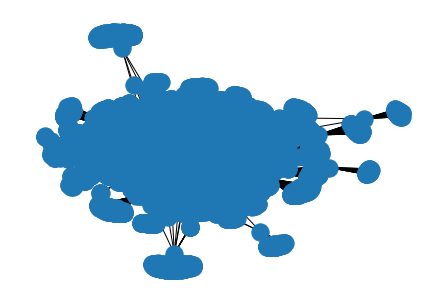

In [8]:
#import networkx as nx
#G = nx.from_pandas_edgelist(edges_final, 
 #                           source='name',
 #                           target='title')
#nx.draw_spring(G)
#nx.draw(G, pos=nx.spring_layout(G))